## How Do Tennis Players' Best Standing and Age Relate to Their Current Performance
Group 13

## Introduction

Tennis is one of the world’s most popular sports to the extent where there have been many international competitions created for professional athletes. All of the tennis data from major tennis tournaments each year is collected and published on the Ultimate Tennis Statistics website for other tennis fans to visit. One popular competition is the Open Era men’s tennis competition. This specific international tournament consists of some of the world’s best tennis players each year. Between the years 2017 and 2019, the data of the top 500 players in the Open Era men’s tennis were collected and shared online. The specific data set that we will be using within this project is the data set called “Player Stats for Top 500 Players”, which is found on the Ultimate Tennis Statistics website. The data that was collected in this dataset provides the necessary information that can be used to analyze and evaluate the question investigated in this project. That said, the question that we will be analyzing is if age and best ranking play a role in whether a player is found within the top 150 athletes. We will be doing this by using a k-nearest neighbour classification model where the predicting variables are the age of the players as well as their best ranking. The ranking columns will be divided into the top 150 and non-top 150 players as the question being investigated is considered a classification problem.  We are predicting that the age of the player will impact their performance. We also expect that older players will have a higher rank compared to younger players due to their expertise in the sport. 

## Methods and Results

In [2]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The dataset we have chosen is the statistics of the top 500 players, which gives the statistics of the top 500 tennis players. By using this dataset, we can predict if a tennis player is currently ranked in the top 150 by their age and their best ranking.

In [3]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


After loading the data, we first selected any columns that might be relevant to our study topic, these were age, prize money, current ranking, best ranking, match, backhand, and height. After we checked the NA values in each column, the NA values in the height column were very high, so we chose not to include the height column in our model.

In [4]:
set.seed(999)
#select the variables we want to use and check how many NA rows there are in each column.
tennis_data <- tennis |>
  select(Age, 'Prize Money', 'Current Rank', 'Best Rank', Plays, Backhand, Height) |>
map_df(~sum(is.na(.)))
print("Table 1")
tennis_data

[1] "Table 1"


Age,Prize Money,Current Rank,Best Rank,Plays,Backhand,Height
<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,81,5,1,47,92,385


After that, we check the details of each variable. The table shows that the Plays and Backhand columns are categorical variables and may not be good predictors, so we chose not to use these two variables in the model.

In [5]:
set.seed(999)
#check the values of each column
tennis_data <- tennis |>
select(Age, 'Prize Money', 'Current Rank', 'Best Rank', Plays, Backhand) 
names(tennis_data) <- c("Age", "Prize", "Current_rank", 'Best_rank', "Plays", "Backhand")
tennis_data <- tennis_data |>
  select(Age, Prize, Current_rank, Best_rank, Plays, Backhand)
print("Table 2")
head(tennis_data)

[1] "Table 2"


Age,Prize,Current_rank,Best_rank,Plays,Backhand
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
26 (25-04-1993),NA,378 (97),363 (04-11-2019),Right-handed,NA
18 (22-12-2001),"$59,040",326 (119),316 (14-10-2019),Left-handed,Two-handed
32 (03-11-1987),"US$3,261,567",178 (280),44 (14-01-2013),Right-handed,Two-handed
21 (29-05-1998),"$374,093",236 (199),130 (10-04-2017),Right-handed,Two-handed
27 (21-10-1992),"US$6,091,971",183 (273),17 (11-01-2016),Right-handed,Two-handed
22 (11-02-1997),"$1,517,157",31 (1398),31 (20-01-2020),Right-handed,Two-handed


By following the steps below, we remove all special symbols such as date of birth, dollar sign, etc. from each column and filter out any rows that contain NA values for the selected column. In addition, by using the iselse function, we divide the current ranking columns into two categories, i.e. top 150 and non-top 150, which will be the outcome of our model.

In [6]:
set.seed(999)
tennis_data <- tennis_data |>
select(Age, Prize, Current_rank, Best_rank) |>
mutate(across(Age: Best_rank, function(col) {str_extract(col, "^[^ ]+")}))|>
mutate(Prize = as.numeric(gsub("[^0-9.]+", "", Prize)))|>
                mutate(Age = as.numeric(Age))|>
                mutate(Current_rank = as.numeric(Current_rank)) |>
                mutate(Best_rank = as.numeric(Best_rank)) |>
  filter(!is.na(Prize) & !is.na(Age) & !is.na(Current_rank) & !is.na(Best_rank)) |>
  mutate(rank_top_150 = ifelse(Current_rank <= 150, "top 150", "not top 150")) |> # convert chr to fct
    mutate(rank_top_150 = as.factor(rank_top_150)) |>
  select(Age, Prize, rank_top_150, Best_rank)#select only the columns we need
print("Table 3")
head(tennis_data)

[1] "Table 3"


Age,Prize,rank_top_150,Best_rank
<dbl>,<dbl>,<fct>,<dbl>
18,59040,not top 150,316
32,3261567,not top 150,44
21,374093,not top 150,130
27,6091971,not top 150,17
22,1517157,top 150,31
28,278709,not top 150,213


Then, we first use the initial_split function to separate the data to training and test sets. We specify that prop = 0.75 so that 75% of our original data set ends up in the training set. We can see from glimpse in the code that the training set contains 294 rows, while the test set contains 99 rows, which corresponds to the split of 75% / 25%.

In [7]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = rank_top_150)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 294
Columns: 4
$ Age          <dbl> 18, 32, 21, 27, 28, 21, 30, 30, 26, 24, 21, 28, 20, 22, 2…
$ Prize        <dbl> 59040, 3261567, 374093, 6091971, 278709, 59123, 184328, 1…
$ rank_top_150 <fct> not top 150, not top 150, not top 150, not top 150, not t…
$ Best_rank    <dbl> 316, 44, 130, 17, 213, 229, 171, 277, 293, 291, 228, 166,…
Rows: 99
Columns: 4
$ Age          <dbl> 22, 25, 20, 28, 23, 30, 22, 30, 22, 28, 26, 34, 27, 22, 3…
$ Prize        <dbl> 1517157, 122734, 74927, 303458, 54004, 898701, 87942, 631…
$ rank_top_150 <fct> top 150, not top 150, top 150, top 150, not top 150, top …
$ Best_rank    <dbl> 31, 253, 104, 143, 319, 98, 312, 75, 238, 164, 371, 48, 2…


The ggplot function was used to generate scatter plots to see the correlation of each numerical variable. 

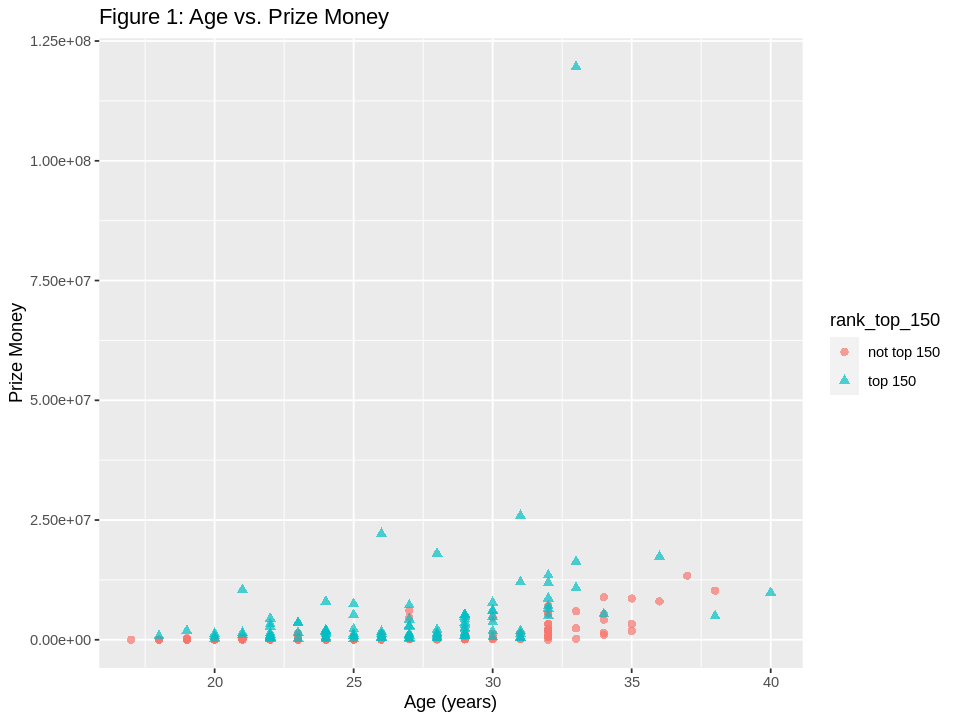

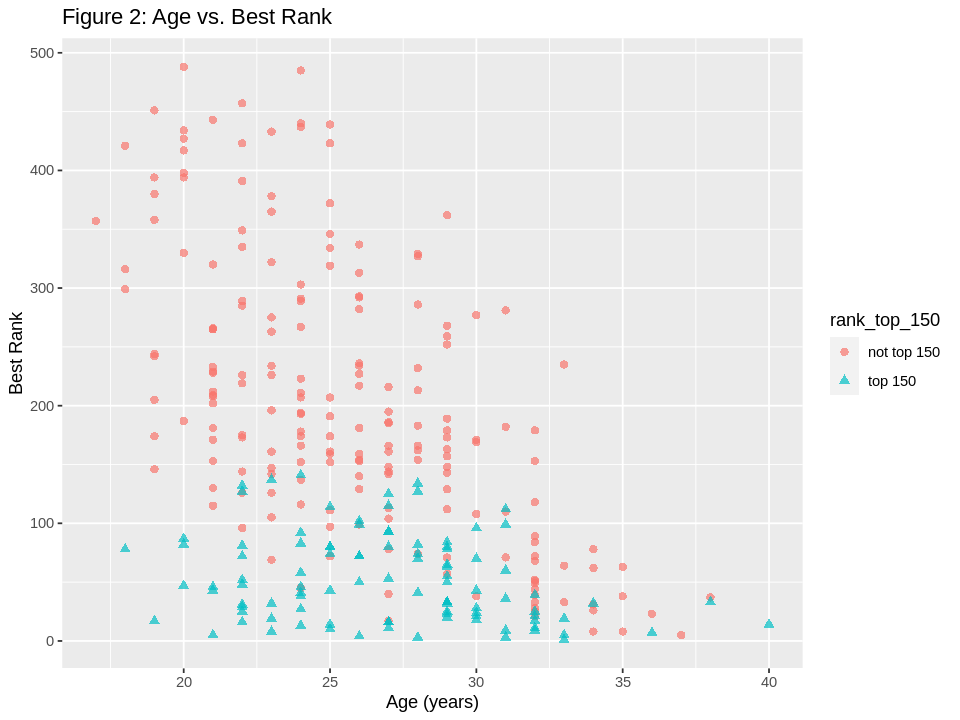

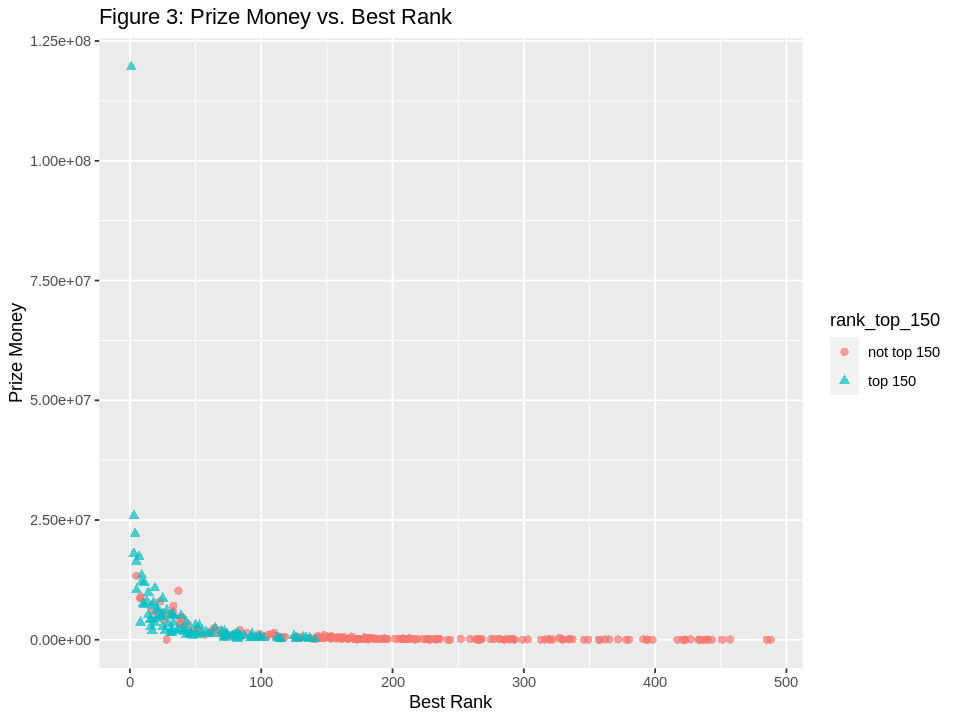

In [8]:
set.seed(999)
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tennis_train, aes(x = Age, y = Prize, color = rank_top_150,
                                            shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Figure 1: Age vs. Prize Money", 
    x = "Age (years)", y = "Prize Money") 

ggplot(tennis_train, aes(x = Age, y = Best_rank, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Figure 2: Age vs. Best Rank", 
    x = "Age (years)", y = "Best Rank") 


ggplot(tennis_train, aes(x = Best_rank, y = Prize, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Figure 3: Prize Money vs. Best Rank", 
    x = "Best Rank", y = "Prize Money") 

The mean and standard deviation of the age, best ranking and prize money of top_150 and not_top_150 were calculated using the summarize function. According to the results, the average age of top 150 tennis players is 1.2 years older than that of non-top 150 tennis players, the average best ranking of top 150 tennis players is about 3.85 times that of non-top 150 tennis players, and the average prize money of top 150 tennis players is 5.65 times more than that of non-top 150 tennis players. 
In addition, the age standard deviation of the top 150 tennis players was 0.3 less than that of the non-top 150 tennis players, the best ranking standard deviation of the top 150 tennis players was approximately 3.15 times higher than that of the non-top 150 tennis players, and the prize money standard deviation of the top 150 tennis players was approximately 6.55 times higher than that of the non-top 150 tennis players. 

In [9]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    avg_age = mean(Age),
    avg_best_rank = mean(Best_rank),
    avg_Prize = mean(Prize)
  )
print("Table 4")
tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    sd_age = sd(Age),
    sd_best_rank = sd(Best_rank),
    sd_Prize = sd(Prize)
  )
print("Table 5")
tennis_summary_sd

[1] "Table 4"


rank_top_150,avg_age,avg_best_rank,avg_Prize
<fct>,<dbl>,<dbl>,<dbl>
not top 150,25.75897,202.25128,886894.7
top 150,26.96970,52.45455,5011293.7


[1] "Table 5"


rank_top_150,sd_age,sd_best_rank,sd_Prize
<fct>,<dbl>,<dbl>,<dbl>
not top 150,4.475403,117.6414,1925523
top 150,4.195368,37.3951,12608122


According to Figure 1, there is a very high prize money, which is probably the reason there is so much overlap at the bottom of the plot. From the trend, we can see that as the age increases, so does the prize money, however, there is so much overlap that it is hard to say if the top 150 players have a higher prize than the non-top 150 players.

In Figure 2 we can see that there is not a lot of overlap and the data is relatively clear. From the data in the graph, we can see a fairly clear trend, which is that the older the age, the higher their best ranking, and most of the top 150 players have a higher best ranking than the non-top 150 players.

As in Figure 1, there is a very high prize data in Figure 3, which may be the reason for the high overlap at the bottom of the graph. It appears from the graph that despite the high overlap, there is a clear trend that the higher the best ranking, the higher the prize received, and that the top 150 receive a higher prize than the non-top 150.

According to the scatter plots, the variables in figure 1 and figure 3 have a high degree of overlap, but the figure 2, which is the age and best rank plot do not have much overlap. Therefore, we will use only age and best ranking as predictor variables in our model.

In [10]:
set.seed(999)
#select the final variables that we need for our model
tennis_data <- tennis_data |>
select(Age, rank_top_150, Best_rank)
print("Table 6")
head(tennis_data)

[1] "Table 6"


Age,rank_top_150,Best_rank
<dbl>,<fct>,<dbl>
18,not top 150,316
32,not top 150,44
21,not top 150,130
27,not top 150,17
22,top 150,31
28,not top 150,213


The table below shows the percentage of top 150 and non-top 150 tennis players, and it can be seen that after we filter out the rows containing NA values, the number of top 500 players is left at 294, with 99 top 150 players and 195 non-top 150 players. In terms of percentages, about 1/3 of tennis players are top 150 and 2/3 of tennis players are not top 150.

In [11]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(rank_top_150) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

print("Table 7")
tennis_proportions

[1] "Table 7"


rank_top_150,n,percent
<fct>,<int>,<dbl>
not top 150,195,66.32653
top 150,99,33.67347


The scatter plots below shows the correlation between the age of the players and their best rank on the x and y axes. According to the plot, it appears that the older the player are, their best ranking gets higher, while the top 150 players have a higher percentage of best rankings than non-top 150 players. 

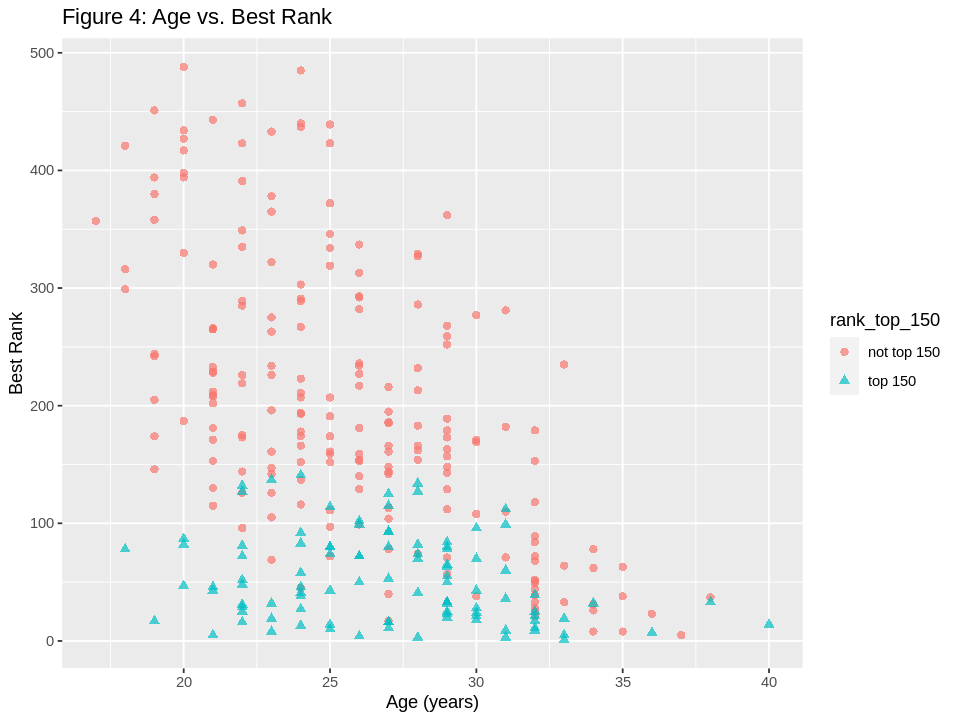

In [12]:
set.seed(999)
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tennis_train, aes(x = Age, y = Best_rank, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Figure 4: Age vs. Best Rank", 
    x = "Age (years)", y = "Best Rank") 

The k-nearest neighbors（knn) algorithm is used to find the optimal set of hyperparameters. The performance of the model is evaluated using 10-fold cross-validation. The accuracy is used to assess the performance of our model. 

In [13]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(rank_top_150 ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = rank_top_150)

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracy <- knn_results |>
                 filter(.metric == 'accuracy')
print("Table 8")
accuracy

[1] "Table 8"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8196059,10,0.01970333,Preprocessor1_Model1
4,accuracy,binary,0.8474384,10,0.01477418,Preprocessor1_Model2
5,accuracy,binary,0.8438834,10,0.01315315,Preprocessor1_Model3
6,accuracy,binary,0.8438834,10,0.01315315,Preprocessor1_Model4
7,accuracy,binary,0.8475616,10,0.01556116,Preprocessor1_Model5
9,accuracy,binary,0.8541051,10,0.01467654,Preprocessor1_Model6
10,accuracy,binary,0.8541051,10,0.01467654,Preprocessor1_Model7
12,accuracy,binary,0.8474384,10,0.01704753,Preprocessor1_Model8
14,accuracy,binary,0.8644663,10,0.01379148,Preprocessor1_Model9


We can determine the best value of k to enhance the accuracy of the model by examining the connection between k and accuracy. This data can be employed to increase the model's efficiency and generate more precise forecasts.

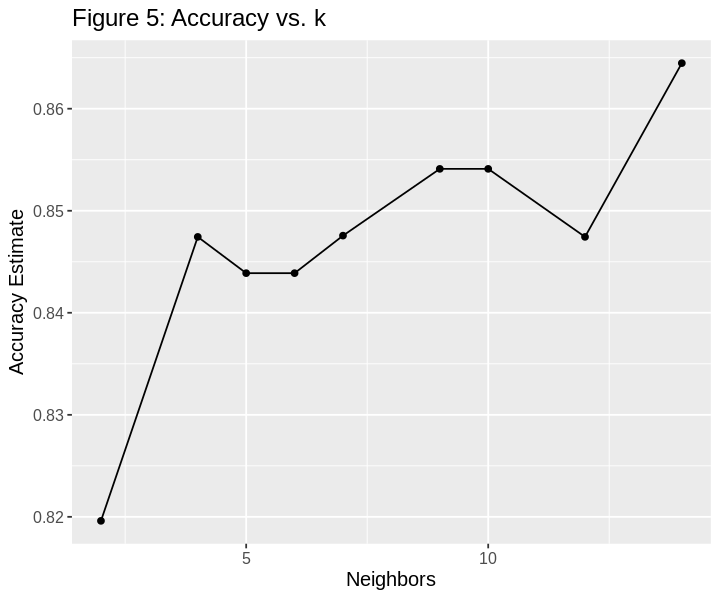

In [14]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(title = 'Figure 5: Accuracy vs. k',
                       x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

According to the above figure, the number of neighbors should be 13-14 in order to get the highest accuracy, so we set K = 14. By following the steps below, we can help test the accuracy of our model. 

In [15]:
set.seed(999)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1428571
Best kernel: rectangular
Best k: 14

Finally, we can test the accuracy of our model with test set and get the accuracy data chart. From the results, it shows that our model has 86.87% accuracy, and out of 99 test observations, 86 are detected correctly and 13 are incorrect.

In [17]:
set.seed(999) 
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
print("Table 9")
head(tennis_predictions)

tennis_metrics <- tennis_predictions |>
         metrics(truth = rank_top_150, estimate = .pred_class) |>
  filter(.metric == "accuracy")
print("Table 10")
tennis_metrics

tennis_mat <- tennis_predictions |>
         conf_mat(truth = rank_top_150, estimate = .pred_class)
print("Table 11")
tennis_mat


Age,rank_top_150,Best_rank
<dbl>,<fct>,<dbl>
22,top 150,31
25,not top 150,253
20,top 150,104
28,top 150,143
23,not top 150,319
30,top 150,98


ERROR: [1m[33mError[39m in [1m[1m`validate_column_names()`:[22m
[33m![39m The following required columns are missing: 'Prize'.


We found that there is definitely a correlation between rank, the player's best rank, and the player's current rank. with an accuracy of 86.87% we are now able to predict whether a player is in the top 150 or not, based on their highest rank and their age.
We took the columns relating to age, prize money, best rank, and current rank. we then mutated the table to convert current rank into whether the player is in the top 150 or not.  after plotting a few graphs with the remaining 3 columns, we found that age and best rank has the most obvious correlation to whether the player's current rank is within the top 150 or not, therefore leading us to create a model using best rank and age, finding the optimal 'k', and creating a prediction model that has a 86.87% accuracy rate.

## Discussion

We predicted whether the player is within the top 150 or not based on their age and their best ranking. We used the k-nearest neighbour classification model to predict if the players are included in the top 150 ranks and used age and best-ranking columns as predictor variables. Since our question is a classification question, we have divided the current ranking column into top 150 and non-top 150. 

Based on the plot we came up with, we found that as age increases, the better a player's best ranking gets, which is in line with our expectation that as a player's career increases, the more likely they are to refresh their best ranking, since skill training is the only way to improve skills performance (“5-Factors,” 2022). One thing about the choice of variables that was not expected was that at the beginning, we thought that prize money must be an important variable in predicting whether a player is in the top 150, but after looking at its correlation with age and best ranking, we were surprised to find that it is not a good variable. 

Our finding of age and player’s best rank would have an impact in such that we can predict whether a player will rank in the top players to some degree. Our prediction model can now be applied to different sets with different data. Research conducted by Reid & Morris also found that the best professional rankings of players are positively related to the age when they entered the top 100; age is associated with the ranking milestones (Reid & Morris, 2013). Based on our findings, we can ask further questions if older players are necessarily better than younger players. Moreover, we can draw the possibility of older players winning a game using regression to find the quantitative result. 
 

## References

1. Ultimate Tennis Statistics. (n.d.). Ultimate Tennis Statistics. Retrieved April 12, 2023, from https://www.ultimatetennisstatistics.com/ 

2. 5 Factors Influencing Sports Performance. WorkoutHealthy. (2022, September 24). Retrieved April 12, 2023, from https://www.workouthealthy.com/blog-sports-performance#:~:text=Bodily%20proportions%2C%20skills%20training%2C%20strength,group%20affect%20your%20sports%20performance. 

3. Reid, M., & Morris, C. (2013). Ranking benchmarks of top 100 players in men's professional tennis, European Journal of Sport Science, 13:4, 350-355, DOI: 10.1080/17461391.2011.608812